In [1]:
import os
import pandas as pd
import sleap
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from pathlib import Path

# Step 1

This notebook processes labeled data to extract video age information and prepare datasets for model development. It outputs a CSV file summarizing video ages, a CSV detailing train-test splits, and a bar plot visualizing the age distribution.

### User-Defined Inputs
- **Labels Path**: Path to the input labeled data (`user_labels`), which must be specified before running the notebook.
- **Fractions for Data Splitting**:  
  - `fraction_train`: Proportion of data to be allocated to the training set.  
  - `val_test_fraction`: Proportion of the remaining data to be allocated to the test set.

### Key Functionalities
1. **Extracting Video Age Information**:  
   - Extracts the age (in days) from video filenames of labeled data.  
   - Saves the results to a CSV file (`video_ages.csv`).  
   - Generates a bar plot visualizing the age distribution.

2. **Splitting Data for Training**:  
   - Divides the labeled data into training, validation, and test sets using specified fractions.  
   - Repeats the split three times, saving datasets to directories (`train.pkg.slp`, `val.pkg.slp`, `test.pkg.slp`) with associated images.  
   - Records metadata for each split, including file path, version, labeled frames, and split type, in a CSV file (`train_test_splits_info.csv`).

### Outputs
- A CSV file (`video_ages.csv`) with video filenames and corresponding age information.  
- A CSV file (`train_test_splits_info.csv`) summarizing train-test splits.  
- A bar plot visualizing the age distribution.  

In [2]:
# labels path
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/soybean/labels_soybean_primary_6nodes.v004.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/sorghum/labels_sorghum_5-12DAG_primary_6nodes.v008.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/lateral/sorghum/sorghum_lateral_roots_4nodes_labels.v001.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/lateral/soybean/labels_soy_lateral_4nodes.v007.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/canola/labels_ONLYcanola_primary_6nodes.v000.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/pennycress/labels_pennycress_primary_6nodes.v000.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/lateral/arabidopsis/labels_arabidopsis_lateral_4nodes.v010.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/arabidopsis/labels_ONLYarabidopsis_primary_6nodes.v000.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/pennycress/labels_ONLYpennycress_primary_6nodes.v000.slp"
# labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/canola/labels_ONLYcanola_primary_6nodes.v000.slp"
labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/younger_rice/labels_rice_primary_6nodes.v006.slp"

# train, val and test fractions
fraction_train = 0.7 # fraction of total user labels to be used for training
val_test_fraction = 0.5 # 1-`fraction_train` allocated for validation and testing

# Directory output path
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/soybean"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/sorghum"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/lateral/sorghum"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/lateral/soybean"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/canola"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/pennycress"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/lateral/arabidopsis"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/arabidopsis"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/pennycress"
# output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/canola"
output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/younger_rice"

In [3]:
# Function to extract the age from the filename (for younger rice)
# D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-1x-r8.h5S
# D:/SLEAP/SLEAP_Rice/3_do/h5_files/Day3_4-18-2022/F22HK4M.h5
def extract_age(filename):
    match = re.search(r'(\d+)DAG', filename)
    match2 = re.search(r'(\d+)_do', filename)
    if match:
        print(f"Extracted age: {match.group(1)} from filename: {filename}")
        return int(match.group(1))
    elif match2:
        print(f"Extracted age: {match2.group(1)} from filename: {filename}")
        return int(match2.group(1))
    else:
        print(f"Age not found in filename: {filename}")
        return 'NA'

In [4]:
# Function to extract the age from the filename (for sorghum dataset)
# def extract_age(filename):
#     match = re.search(r'Day(\d+)_', filename)
#     if match:
#         print(f"Match found: {match.group(1)}")
#         return match.group(1)
#     else:
#         print(f"Match not found for {filename}")
#         return 'NA'

In [5]:
# Function to extract the age from the filename (for soybean dataset)
# h5_files_blue_6_do_1.17.22
# def extract_age(filename):
#     match = re.search(r'_(\d+)_do', filename)
#     if match:
#         print(f"Match found: {match.group(1)}")
#         return match.group(1)
#     else:
#         print(f"Match not found for {filename}")
#         return 'NA'

In [6]:
# Function to extract the age from the filename (for canola dataset)

# 'D:/SLEAP/SLEAP_Canola_Pennycress/primary_root/h5_files_for_PR_sleap_project/9_do/33PFABDMTW.h5'
# Z:/Experiments/Canola/CYL_Canola_Diversity_Screen/Downstream_Data_Extraction_and_Analysis/4-19-23_data_v000_not_qc_not_proofread/H5_w_SLEAP_predictions_preqc_preproofread/W22/2do/HMDQXXWRSQ.h5
# D:\SLEAP\SLEAP_Canola_Pennycress\primary_root\h5_files_for_PR_sleap_project\pennycress\14_do
# def extract_age(filename):
#     match = re.search(r'(\d+)_do', filename)
#     match2 = re.search(r'(\d+)do', filename)
#     if match:
#         print(f"Match found: {match.group(1)}")
#         # Check to see if it is pennycress
#         if 'pennycress' in filename:
#             return f"pennycress_{match.group(1)}"
#         return match.group(1)
#     elif match2:
#         print(f"Match found: {match2.group(1)}")
#         return match2.group(1)
#     else:
#         print(f"Match not found for {filename}")
#         return 'NA'

In [7]:
# Function to extract the age from the filename (for pennycress dataset)
# D:\SLEAP\SLEAP_Canola_Pennycress\primary_root\h5_files_for_PR_sleap_project\pennycress\14_do
# D:/SLEAP/SLEAP_Canola_Pennycress/lateral_3_nodes/h5_files_for_LR_sleap_project/pennycress_round2/7P2M34R81D.h5
# def extract_age(filename):
#     match = re.search(r'(\d+)_do', filename)
#     match2 = re.search('pennycress_round2', filename)
#     if match:
#         print(f"Match found: {match.group(1)}")
#         return match.group(1)
#     elif match2:
#         print(f"Match found: {match2.group(0)}")
#         return 14
#     else:
#         print(f"Match not found for {filename}")
#         return 'NA'

In [8]:
# Function to extract the age from the filename (for arabidopsis dataset)
# D:/SLEAP/SLEAP_arabidopsis/h5_files_7dap_041522/1027_E_R1.h5
# D:/SLEAP/SLEAP_arabidopsis/h5_files_reorganized/11_days/DMSO/1002_1.h5
# def extract_age(filename):
#     match = re.search(r'_(\d+)dap', filename)
#     match2 = re.search(r'(\d+)_days', filename)
#     if match:
#         print(f"Match found: {match.group(1)}")
#         return match.group(1)
#     elif match2:
#         print(f"Match found: {match2.group(1)}")
#         return match2.group(1)
#     else:
#         print(f"Match not found for {filename}")
#         return 'NA'

In [9]:
# arabidopsis, pennycress and canola
# def extract_age(filename):
#     match_pennycress = re.search(r'pennycress', filename)
#     match_arabodopsis = re.search(r'arabidopsis', filename)
#     # match_canola1 =  re.search(r'(\d+)_do', filename)
#     # match_canola2 = re.search(r'(\d+)do', filename)
#     if match_pennycress:
#         return 'pennycress'
#     elif match_arabodopsis:
#         print(f"Match found for {filename}")
#         return 'arabidopsis'
#     else:
#         print(f"Match not found for {filename}")
#         return 'NA'

In [10]:
base_labels = sleap.load_file(Path(labels_path).as_posix()) # load labels file
user_labels = base_labels.with_user_labels_only() # user instances only

In [11]:
# Make the output directory if it doesn't exist
Path(output_path).mkdir(parents=True, exist_ok=True)

In [12]:
# Print the first few items to check their structure
for label in user_labels[:5]:
    print(label)

LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-1x-r8.h5'), frame_idx=0, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-1x-r8.h5'), frame_idx=21, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r2.h5'), frame_idx=0, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r2.h5'), frame_idx=21, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r3.h5'), frame_idx=0, instances=1)


In [13]:
print(f"There are {len(user_labels)} labels total.")

# Variables to keep count of matches and non-matches
match_count = 0
no_match_count = 0

# Create a DataFrame from the canola labels
data = []
for label in user_labels:
    age = extract_age(label.video.filename)
    if age != 'NA':
        match_count += 1
    else:
        no_match_count += 1
    data.append({'video_filename': label.video.filename, 'days_old': age})

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file = Path(output_path) / 'video_ages.csv'
df.to_csv(csv_file, index=False)

print(f"Details saved to {csv_file}")
print(f"Number of labeled frames with age found: {match_count}")
print(f"Number of labeled frames with age not found: {no_match_count}")


There are 1053 labels total.
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-1x-r8.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-1x-r8.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r2.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r2.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r3.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r3.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r4.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r4.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r1.h5
Extracted age: 5 from filename: D:/SLEAP/SLEAP_Rice/Hydroponic/5DAG_primary/h5_files/hg-0x-r1.h5
E

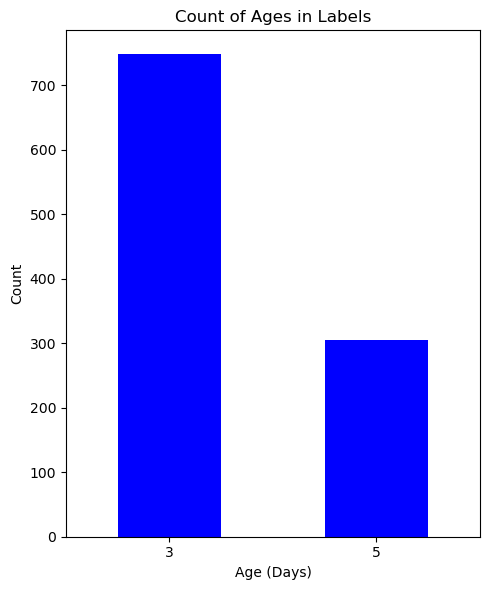

Plot saved to D:\SLEAP\20250102_generalizability_experiment\primary\younger_rice\age_distribution.png


In [14]:
# Ensure the ages are treated as integers
df['days_old'] = df['days_old'].astype(int)

# Plotting the bar graph
age_counts = df['days_old'].value_counts().sort_index()
plt.figure(figsize=(5, 6), facecolor='white') 
age_counts.plot(kind='bar', color='blue')  # Set color to blue
plt.title('Count of Ages in Labels')
plt.xlabel('Age (Days)')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate the x-axis labels
plt.tight_layout()  # Adjusts the plot to ensure a tight fit

# Save the figure
plot_path = Path(output_path) / 'age_distribution.png'
plt.savefig(plot_path, facecolor='white', bbox_inches='tight')
plt.show()

print(f"Plot saved to {plot_path}")

In [15]:
n_train = int(fraction_train*len(user_labels))
print(f"Number of labels for training set should be {n_train}.")
n_val = int((1-fraction_train)*val_test_fraction*len(user_labels))
print(f"Number of labels for validation set should be {n_val}.")
n_test = int((1-fraction_train)*val_test_fraction*len(user_labels))
print(f"Number of labels for validation set should be {n_test}.")

Number of labels for training set should be 737.
Number of labels for validation set should be 157.
Number of labels for validation set should be 157.


In [16]:
# Initialize a list to store information for the CSV file
csv_data = []

for i in range(3):
    # Split the training and validation sets
    labels_train, _, labels_val, _ = sleap.nn.data.training.split_labels_train_val(user_labels, 1-fraction_train) # 1-`fraction_train` allocated for validation and testing
    labels_val, _, labels_test, _ = sleap.nn.data.training.split_labels_train_val(labels_val, val_test_fraction) # `val_test_fraction` of `labels_val` made into a test set

    # Make a directory for this split
    split_dir = Path(output_path) / f"train_test_split.v00{i}"
    os.makedirs(split_dir, exist_ok=True)

    # Save the train, val and test sets
    train_path = Path(split_dir) / "train.pkg.slp"
    val_path = Path(split_dir) / "val.pkg.slp"
    test_path = Path(split_dir) / "test.pkg.slp"
    labels_train.save(train_path, with_images=True)
    labels_val.save(val_path, with_images=True)
    labels_test.save(test_path, with_images=True)

    # Store the information in the list for train, val and test splits
    csv_data.append({'path': train_path, 'version': i, 'labeled_frames': len(labels_train), 'split_type': 'train'})
    csv_data.append({'path': val_path, 'version': i, 'labeled_frames': len(labels_val), 'split_type': 'val'})
    csv_data.append({'path': test_path, 'version': i, 'labeled_frames': len(labels_test), 'split_type': 'test'})

In [17]:
# Convert the list to a DataFrame and save as CSV
df_new = pd.DataFrame(csv_data)
csv_path = Path(output_path) / 'train_test_splits.csv'
df_new.to_csv(csv_path, index=False)

print(f"Train, val and test splits information saved to {csv_path}")

Train, val and test splits information saved to D:\SLEAP\20250102_generalizability_experiment\primary\younger_rice\train_test_splits.csv


In [18]:
df_new

,path,version,labeled_frames,split_type
0,D:\SLEAP\20250102_generalizability_experiment\...,0,737,train
1,D:\SLEAP\20250102_generalizability_experiment\...,0,158,val
2,D:\SLEAP\20250102_generalizability_experiment\...,0,158,test
3,D:\SLEAP\20250102_generalizability_experiment\...,1,737,train
4,D:\SLEAP\20250102_generalizability_experiment\...,1,158,val
5,D:\SLEAP\20250102_generalizability_experiment\...,1,158,test
6,D:\SLEAP\20250102_generalizability_experiment\...,2,737,train
7,D:\SLEAP\20250102_generalizability_experiment\...,2,158,val
8,D:\SLEAP\20250102_generalizability_experiment\...,2,158,test
